In [1]:
from pathlib import Path
from os.path import join
from google.cloud import bigquery
from google.oauth2 import service_account


path = Path(__file__).resolve()
ROOT_PATH = path.parents[2]
ENV_PATH = ROOT_PATH / 'env'

# Credential are stored away from the project folder
CREDENTIALS_PATH = str(ENV_PATH / 'google_gfw_credentials.json')

# 1) Google BigQuery on fishing efforts (data from Gloabl Fishing Watch)
## 1.1) Instantiate Google BigQuery object that will perform queries

Data from Global Fishing Watch about vessels' fishing efforts have been downloaded from https://globalfishingwatch.org/data-download/datasets/public-fishing-effort. The ``fishing-vessels-v2.xlsx`` csv file has been processed and uploaded to Google BigQuery. Then an API wrapper has been generated to be able to access from outside while using private credentials.

In [2]:
credentials = service_account.Credentials.from_service_account_file( CREDENTIALS_PATH, scopes=["https://www.googleapis.com/auth/cloud-platform"],)
client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

## 1.2) Find total number of vessel with flags

Of the three fields ``flag_gfw``, ``flag_registry`` and ``flag_ais`` find which one has more boats identified

In [3]:
table = "gfw-testing-377510.fishing_efforts.fishing_data"
query = f"""
SELECT
  CONCAT(FORMAT ("%'.2f", SUM(CASE
          WHEN flag_gfw IS NOT NULL THEN 1
        ELSE
        0
      END
        ) / COUNT(*) * 100), '%') AS num_flag_gfw,
  CONCAT(FORMAT ("%'.2f", SUM(CASE
          WHEN flag_ais IS NOT NULL THEN 1
        ELSE
        0
      END
        ) / COUNT(*) * 100), '%') AS num_flag_ais,
  CONCAT(FORMAT ("%'.2f", SUM(CASE
          WHEN flag_registry IS NOT NULL THEN 1
        ELSE
        0
      END
        ) / COUNT(*) * 100), '%') AS num_flag_registry
FROM
  {table}
  """
query_job = client.query(query)

In [4]:
query_job.to_dataframe()

,num_flag_gfw,num_flag_ais,num_flag_registry
0,99.22%,79.79%,21.59%


## 1.3) Find what countries had the most accumulated fishing hours

Next query obtains the list of countries, fishing gear and total fishing hours per country and gear and country. All gears for all countries are fetched but the results are sorted by the total fishing hours per gear in descending order. We use ``flag_gfw`` as it was the flag that identified the most vessels. 


In [5]:
query = f"""
SELECT
  flag_gfw,
  vessel_class_gfw,
  SUM(fishing_hours_2012 + fishing_hours_2013 + fishing_hours_2014 + fishing_hours_2015 + fishing_hours_2016 + fishing_hours_2017 + fishing_hours_2018 + fishing_hours_2019 + fishing_hours_2020) AS total_fishing_hours
FROM
  {table}
WHERE
  flag_gfw IS NOT NULL
  AND vessel_class_gfw IS NOT NULL
GROUP BY
  flag_gfw,
  vessel_class_gfw
HAVING
  total_fishing_hours IS NOT NULL
ORDER BY
  total_fishing_hours DESC,
  flag_gfw
"""
query_job = client.query(query)

In [6]:
query_job.to_dataframe().head(15)

,flag_gfw,vessel_class_gfw,total_fishing_hours
0,FRA,trawlers,6323317.82
1,RUS,trawlers,5230893.76
2,KOR,drifting_longlines,4225950.01
3,CHN,trawlers,3085546.93
4,ESP,drifting_longlines,3071283.75
5,JPN,drifting_longlines,2822906.47
6,ITA,trawlers,2491535.95
7,ESP,trawlers,2412337.95
8,NLD,trawlers,2299255.37
9,DNK,trawlers,2156840.78


## 1.4) Find the gear per country that had the most accmulated fishing ours over the 2012-2020 period

Contrary to the the earlier query, the next one will find the one gear per country with most accummulated fishing hours over the period 2012-2020. No country is therefore repeated in the list. The resulting list is sorted by the number of fishing hours in descending order. 

To avoid performance issues a **group-wise max query** has been used instead of subqueries.


In [7]:
most_fishing_hours_query = f"""
SELECT
    flag_gfw,
    vessel_class_gfw,
    SUM(fishing_hours_2012 + fishing_hours_2013 + fishing_hours_2014 + fishing_hours_2015 + fishing_hours_2016 + fishing_hours_2017 + fishing_hours_2018 + fishing_hours_2019 + fishing_hours_2020) AS total_fishing_hours
  FROM
    {table}
  WHERE
    flag_gfw IS NOT NULL
    AND vessel_class_gfw IS NOT NULL
  GROUP BY
    flag_gfw,
    vessel_class_gfw
  HAVING
    total_fishing_hours IS NOT NULL
"""

query = f"""
SELECT
  q1.flag_gfw,
  q1.vessel_class_gfw,
  FORMAT("%'.2f", q1.total_fishing_hours) as total_fishing_hours
  -- first query calculating most fishing hours per gear and country
FROM ({most_fishing_hours_query}) q1
LEFT JOIN (
    -- second query calculating most fishing hours per gear and country
  {most_fishing_hours_query}) q2
  -- together with left join, for cases where the 'on' condition does not fully apply, q1 results will still be added, however with is counterpart q2 results set as null ...
ON
  q1.flag_gfw = q2.flag_gfw
  AND q1.total_fishing_hours < q2.total_fishing_hours
WHERE
  q2.flag_gfw IS NULL -- ... and the the records with the q2 null values associated are the largest q1 values
ORDER BY
  q1.total_fishing_hours desc,
  q1.flag_gfw
"""
query_job = client.query(query)

In [8]:
results = query_job.to_dataframe()
results.head(len(results))

,flag_gfw,vessel_class_gfw,total_fishing_hours
0,FRA,trawlers,"6,323,317.82"
1,RUS,trawlers,"5,230,893.76"
2,KOR,drifting_longlines,"4,225,950.01"
3,CHN,trawlers,"3,085,546.93"
4,ESP,drifting_longlines,"3,071,283.75"
5,JPN,drifting_longlines,"2,822,906.47"
6,ITA,trawlers,"2,491,535.95"
7,NLD,trawlers,"2,299,255.37"
8,DNK,trawlers,"2,156,840.78"
9,ARG,trawlers,"1,855,625.76"


# 2) Movement Ecology and Graph Theory

In [9]:
%load_ext rpy2.ipython

In [51]:
%%R
source("R/config.R")
source ("R/utils.R")

# Read data and prepare matrix of detections
locs = prepare_gis_receiver_locations(receiver_loc_path, coast)
data <- read.csv(lubina_detection_path)
data <- data %>% mutate(station=ifelse(station == "",  station_folder, station))

Reading layer `coast_cat_fr' from data source 
  `/Users/dgg/Documents/repos/fishery-analysis/src/data/gis_data/coast/coast_cat_fr.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 7 features and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 482744.5 ymin: 4639662 xmax: 526428.2 ymax: 4717745
Projected CRS: WGS 84 / UTM zone 31N
Reading layer `coast_cat_fr_rivers_3' from data source 
  `/Users/dgg/Documents/repos/fishery-analysis/src/data/gis_data/coast/coast_cat_fr_rivers_3.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2 features and 2 fields
Geometry type: LINESTRING
Dimension:     XY
Bounding box:  xmin: 2.791046 ymin: 41.98358 xmax: 3.194144 ymax: 42.20165
Geodetic CRS:  WGS 84
Reading layer `coast_cat_fr_port_3' from data source 
  `/Users/dgg/Documents/repos/fishery-analysis/src/data/gis_data/coast/coast_cat_fr_port_3.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2 features and 2 fields
Geome

In [62]:
%%R
# Generate a graph matrix that contains all loops movement where each node will contain the total movements within zone in %.
only_loops_g <- build_graph_matrix(
  data,
  loop_or_transition = TRUE,
  keep_duplicated_edges = TRUE,
  keep_columns = c('ind_name', 'date_time')
) %>%
  select(from, ind_name, date_time) %>%
  rename(station = from) %>%
  mutate(zone = case_when(
    grepl("M", station, fixed = TRUE) ~ 'M',
    grepl("G", station, fixed = TRUE) ~ 'G',
    grepl("C", station, fixed = TRUE) ~ 'C',
    grepl("B", station, fixed = TRUE) ~ 'B',
  )) %>%
  group_by(zone) %>%
  summarise(detections = n()) %>%
  mutate(percentage = round((detections / sum(detections)) * 100, 2)) %>%
  arrange(desc(percentage)) %>%
  mutate(cum = cumsum(percentage))

only_loops_g  # Medes Islands accumulates 82.3 of all movements

# A tibble: 4 × 4
  zone  detections percentage   cum
  <chr>      <int>      <dbl> <dbl>
1 M         146388      82.3   82.3
2 G          17240       9.69  92.0
3 C          11402       6.41  98.4
4 B           2897       1.63 100  


In [63]:
%%R

# Generate a graph matrix that contains all transition movements where movements between nodes are calculated as a percentange of the total.
no_loops_g <- build_graph_matrix(
  data,
  loop_or_transition = FALSE,
  keep_duplicated_edges = TRUE,
  keep_columns = c('ind_name', 'date_time')
) %>%
  select(from, to, ind_name, date_time) %>%
  mutate(
    zone_interaction = case_when(
      # Medes
      grepl("M", from, fixed = TRUE) &
        grepl("M", to, fixed = TRUE) ~ 'M-M',
      grepl("M", from, fixed = TRUE) &
        grepl("G", to, fixed = TRUE) ~ 'M-G',
      grepl("G", from, fixed = TRUE) &
        grepl("M", to, fixed = TRUE) ~ 'M-G',
      grepl("M", from, fixed = TRUE) &
        grepl("C", to, fixed = TRUE) ~ 'M-C',
      grepl("C", from, fixed = TRUE) &
        grepl("M", to, fixed = TRUE) ~ 'M-C',
      grepl("M", from, fixed = TRUE) &
        grepl("B", to, fixed = TRUE) ~ 'M-B',
      grepl("B", from, fixed = TRUE) &
        grepl("M", to, fixed = TRUE) ~ 'M-B',

      # G
      grepl("G", from, fixed = TRUE) &
        grepl("G", to, fixed = TRUE) ~ 'G-G',
      grepl("G", from, fixed = TRUE) &
        grepl("C", to, fixed = TRUE) ~ 'G-C',
      grepl("C", from, fixed = TRUE) &
        grepl("G", to, fixed = TRUE) ~ 'G-C',
      grepl("G", from, fixed = TRUE) &
        grepl("B", to, fixed = TRUE) ~ 'G-B',
      grepl("B", from, fixed = TRUE) &
        grepl("B", to, fixed = TRUE) ~ 'G-B',

      # C
      grepl("C", from, fixed = TRUE) &
        grepl("C", to, fixed = TRUE) ~ 'C-C',
      grepl("C", from, fixed = TRUE) &
        grepl("B", to, fixed = TRUE) ~ 'C-B',
      grepl("B", from, fixed = TRUE) &
        grepl("C", to, fixed = TRUE) ~ 'C-B',

      # B
      grepl("B", from, fixed = TRUE) &
        grepl("B", to, fixed = TRUE) ~ 'B-B'
    )
  ) %>%
  group_by(zone_interaction) %>%
  summarise(detections = n()) %>%
  mutate(percentage = round((detections / sum(detections)) * 100, 2)) %>%
  arrange(desc(percentage)) %>%
  mutate(cum = cumsum(percentage))
no_loops_g # The interactions beween

# A tibble: 10 × 4
   zone_interaction detections percentage   cum
   <chr>                 <int>      <dbl> <dbl>
 1 M-M                  177940      56.9   56.9
 2 M-G                   72279      23.1   80.0
 3 M-C                   36334      11.6   91.7
 4 G-G                   14116       4.52  96.2
 5 G-C                    6318       2.02  98.2
 6 M-B                    4203       1.34  99.6
 7 C-C                     923       0.3   99.8
 8 C-B                     418       0.13 100. 
 9 G-B                      16       0.01 100. 
10 <NA>                     15       0    100. 


In [64]:
%%R

# --> get % for node size for loops and within station movements
node_size_df <- no_loops_g %>%
  filter(
    if_any(zone_interaction, ~str_detect(., "M-M")) |
      if_any(zone_interaction, ~str_detect(., "G-G")) |
      if_any(zone_interaction, ~str_detect(., "C-C")) |
      if_any(zone_interaction, ~str_detect(., "B-B"))
  ) %>%
  mutate(zone_interaction = str_replace(zone_interaction, "M-M", "M")) %>%
  mutate(zone_interaction = str_replace(zone_interaction, "G-G", "G")) %>%
  mutate(zone_interaction = str_replace(zone_interaction, "C-C", "C")) %>%
  mutate(zone_interaction = str_replace(zone_interaction, "B-B", "B")) %>%
  select(zone_interaction, detections) %>%
  rename(zone = zone_interaction)

node_size_df[nrow(node_size_df) + 1,] = list("B", 1)

# Merge loops and within movements
zone_loops <- only_loops_g %>% select(zone, detections)
node_size_df <- merge(node_size_df, zone_loops, all = TRUE)

# Calculate % in the dataframe
node_size_df <- node_size_df %>%
  group_by(zone) %>%
  summarise(detections = sum(detections)) %>%
  mutate(percentage = round((detections / sum(detections)) * 100, 2)) %>%
  arrange(desc(percentage)) %>%
  mutate(cum = cumsum(percentage))


In [65]:
%%R
# Build edge size
# --> get % edges weight
edge_weight_df <- no_loops_g %>%
  filter(
    !if_any(zone_interaction, ~str_detect(., "M-M")) &
    !if_any(zone_interaction, ~str_detect(., "G-G")) &
    !if_any(zone_interaction, ~str_detect(., "C-C")) &
    !if_any(zone_interaction, ~str_detect(., "B-B"))
  ) %>%
  select(zone_interaction, detections) %>%
  rename(zone = zone_interaction) %>%
  group_by(zone) %>%
  summarise(detections = sum(detections)) %>%
  mutate(percentage = round((detections / sum(detections)) * 100, 2)) %>%
  arrange(desc(percentage)) %>%
  mutate(cum = cumsum(percentage))

In [66]:
%%R
# Build Graph
# --> Get coordinates of representative marine reserves
zone_stations <- locs %>%
  filter(station == 'M08' |
         station == 'G06' |
         station == 'C18' |
         station == 'B17') %>%
  mutate(station = str_replace(station, "M08", "M")) %>%
  mutate(station = str_replace(station, "G06", "G")) %>%
  mutate(station = str_replace(station, "C18", "C")) %>%
  mutate(station = str_replace(station, "B17", "B"))
# Assign node sizes and edge weights

# --> Create the mobility graph between zones in the same exact order as the
# descending edge weight order
zone_graph <- make_undirected_graph(c("M", "G", "M", "C", "G", "C",
                                      "M", "B", "C", "B", "G", "B"))

# --> Get coordinates of graph and bounding box
coords_simple_g <-
  get_graph_coordinates(zone_graph, zone_stations)
bb_simple_g <-
  adjust_coord_bb(coords_simple_g, min_half_size = 2000)
bb_simple_g$ymin[1] <- bb_simple_g$ymin[1] - 2000


V(zone_graph)$size <- node_size_df$percentage
V(zone_graph)$name <- c("Illes Medes", "Badia de Roses", "Cap de Creus", "Banyuls")
E(zone_graph)$weight <- edge_weight_df$percentage

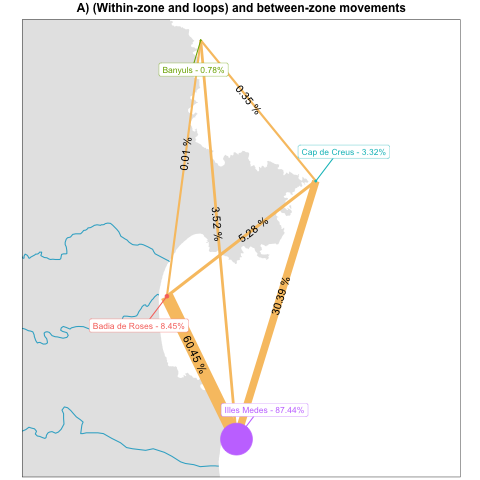

In [68]:
%%R
# Draw finally the graph
zone_graph_plot <- ggraph(zone_graph,
                          layout = "manual",
                          x = coords_simple_g$X,
                          y = coords_simple_g$Y) +

  ggtitle("A) (Within-zone and loops) and between-zone movements") +
  geom_sf(data = coast, col = NA) +
  geom_sf(data = river, col = "#38afcd") +
  geom_sf(data = river_muga, col = "#38afcd") +
  geom_sf(data = port, col = "black") +


  coord_sf(
    xlim = c(bb_simple_g$xmin, bb_simple_g$xmax),
    ylim = c(bb_simple_g$ymin, bb_simple_g$ymax)
  ) +

  geom_edge_link(
    color = '#F8C471',
    aes(
      width = E(zone_graph)$weight / 5,
      label = paste(E(zone_graph)$weight, "%")
    ),
    angle_calc = "along",
    label_push = unit(5, "mm")
  ) +

  # Node settings
  # --> We need a legend
  geom_node_point(aes(colour = V(zone_graph)$name),
                  size = V(zone_graph)$size / 6) +

  geom_node_label(
    aes(
      colour = V(zone_graph)$name,
      label = paste0(V(zone_graph)$name,
                     " - ",
                     V(zone_graph)$size,
                     "%")
    ),
    label.size = 0.15,
    size = 3,
    nudge_x = 4,
    nudge_y = -3,
    repel = TRUE,
    max.overlaps = Inf,
    box.padding = unit(1.5, "lines")
  ) +
  theme_bw() +
  theme(
    legend.position = "none",
    axis.line = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    plot.margin = unit(c(0.1, 0, 0, 0), "cm"),
    plot.title = element_text(size = 12, hjust = 0.5, face = "bold")
  ) +
  xlab(NULL) +
  ylab(NULL)
    
zone_graph_plot
